In [28]:
import preprocess
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [29]:
import warnings
warnings.filterwarnings("ignore")

## Preprocessing Training and Holdout data

In [30]:
df = pd.read_csv('/home/dileep/Desktop/python/All_csvs/process.csv')
pred_train, targ_train = preprocess.getFinal(df).process()
holdout = pd.read_csv('/home/dileep/Desktop/python/All_csvs/holdout.csv')
pred_h, targ_h = preprocess.getFinal(holdout).process()

## Trop and Apache

In [31]:
score_train = pd.read_csv('/home/dileep/Desktop/python/All_csvs/score_train.csv')
score_holdout = pd.read_csv('/home/dileep/Desktop/python/All_csvs/score_holdout.csv')
score_all = pd.read_csv('/home/dileep/Desktop/python/All_csvs/score_all.csv')

In [32]:
survival = {'Alive': 0,'Expired': 1} 
score_all['Survival'] = [survival[item] for item in score_all['Survival']]

In [33]:
# Whole dataset for evaluation - No splitting
trop_all = (score_all['T Pred Mort'])/100
ap_all = (score_all['A PredMort'])/100
sur_all = score_all['Survival']

In [34]:
# Just holdout
trop_h = (score_holdout['T Pred Mort'])/100
ap_h = (score_holdout['A PredMort'])/100
sur_h = score_holdout['Survival']

In [35]:
apache_trop = [trop_all, ap_all, sur_all]

## Training Models

In [9]:
# from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
import xgboost as xgb

SEED = 62

# Creating pipes
pipe_lr = Pipeline(steps=[('clf', LogisticRegression(random_state=42))])
pipe_dtr = Pipeline(steps=[('clf', DecisionTreeRegressor(random_state=42))])
pipe_kn = Pipeline(steps=[('clf', KNeighborsRegressor())])
pipe_br = Pipeline(steps=[('clf', BaggingRegressor(base_estimator=(DecisionTreeRegressor(random_state=SEED,
                                                            max_depth=5, min_samples_leaf=0.1))))])
pipe_rf = Pipeline(steps=[('clf', RandomForestRegressor(random_state=42))])
pipe_brf = Pipeline(steps=[('clf', BaggingRegressor(base_estimator=RandomForestRegressor(max_depth=8, 
                                                                                         max_leaf_nodes=8, 
                                                                                         min_impurity_split=0.01, 
                                                                                         n_estimators=50)))])
pipe_gb = Pipeline(steps=[('clf', GradientBoostingRegressor())])
pipe_sgb = Pipeline(steps=[('clf', GradientBoostingRegressor())])
pipe_xgb = Pipeline(steps=[('clf', xgb.XGBRegressor())])

# Creating params
params_lr = {
    'clf__C' : [0.001, 0.01, 0.1, 1],
    'clf__penalty' : ['l1', 'l2']
}
params_dtr = {
    'clf__max_depth' : np.arange(1,20,5),
    'clf__min_samples_leaf' : [0.05, 0.1]
}
params_kn = {
    'clf__n_neighbors' : np.arange(30,50,10)
}
params_br = {
    'clf__n_estimators' : np.arange(30,100,10),
}
params_rf = {
    'clf__max_depth' : np.arange(2, 20, 6),
    'clf__max_leaf_nodes': np.arange(2,20,6), 
    'clf__min_impurity_split': [0.01, 0.1],
    'clf__n_estimators': np.arange(50, 70, 10)
}
params_brf = {
    'clf__n_estimators' : [90],
}
params_gb = {
    'clf__n_estimators': [20],
    'clf__learning_rate': [0.1], 
    'clf__max_depth': [4]
}
params_sgb = {
    'clf__n_estimators': [20],
    'clf__learning_rate': [0.1], 
    'clf__max_depth': [4], 
    'clf__subsample': [0.8], 
    'clf__max_features': [0.2]
}
params_xgb = {
    'clf__subsample': np.arange(.05, 1, .05),
    'clf__max_depth': np.arange(3,20,1),
    'clf__colsample_bytree': np.arange(.1,1.05,.05) 
}


# Construct grid searches
jobs = -1

gs_lr = RandomizedSearchCV(estimator=pipe_lr, 
                    param_distributions=params_lr,
                    n_iter=5,
                    scoring='roc_auc',
                    cv=5)

gs_dtr = RandomizedSearchCV(estimator=pipe_dtr, 
                    param_distributions=params_dtr,
                    n_iter=5,
                    scoring='roc_auc',
                    cv=5)
grid_kn = RandomizedSearchCV(estimator=pipe_kn, 
                      param_distributions=params_kn, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_br = RandomizedSearchCV(estimator=pipe_br, 
                      param_distributions=params_br,
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_rf = RandomizedSearchCV(estimator=pipe_rf, 
                      param_distributions=params_rf, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_brf = RandomizedSearchCV(estimator=pipe_brf, 
                      param_distributions=params_brf, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_gb = RandomizedSearchCV(estimator=pipe_gb, 
                      param_distributions=params_gb, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_sgb = RandomizedSearchCV(estimator=pipe_sgb, 
                      param_distributions=params_sgb, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_xgb = RandomizedSearchCV(estimator=pipe_xgb, 
                      param_distributions=params_xgb, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)

# List of pipelines
grids = [grid_sgb, grid_gb, grid_brf, grid_rf, grid_br, grid_kn, gs_dtr, gs_lr, grid_xgb, 1]

# Dictionary of pipelines
grid_dict = {0: 'Stochastic Gradient Boost', 1: 'Gradient Boost', 2: 'RF with bagging', 
             3: 'RandomForestRegressor', 4: 'BaggingRegressor', 5: 'KNeighborsRegressor', 6: 'DecisionTree', 
             7: 'Logistic Regression', 8: 'XGBoost', 9: 'Neural Net'}

# Fitting
print('Performing model optimizations...')

X_train, X_test, y_train, y_test = train_test_split(pred_train, targ_train, test_size=0.3, stratify=targ_train, random_state=62)

for idx, gs in enumerate(grids):
    if (grid_dict[idx] == 'Neural Net'):
        print('\nEstimator: %s' % grid_dict[idx])
        
        # Creating NN model
        nn_model = Sequential()
        nn_model.add(Dense(128, activation='relu', input_shape=(25,)))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, kernel_regularizer=regularizers.l2(0.1), activation='relu'))
        nn_model.add(Dense(1))
        # Compiling
        nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        
        nn_model.fit(pred_train, targ_train)
        y_pred_nn = nn_model.predict(pred_train)
        # Scoring
        print('Train set accuracy score for best param: %.3f ' % roc_auc_score(targ_train, y_pred_nn))
        break
    else:
        print('\nEstimator: %s' % grid_dict[idx])
        # Fit grid search
        gs.fit(X_train, y_train)
        # Best params
        print('Best params: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best training accuracy: %.3f' % gs.best_score_)
        if (grid_dict[idx] == 'Logistic Regression'):
            y_pred = gs.predict_proba(X_test)[:, 1]
        else:
            # Predict on test data with best params
            y_pred = gs.predict(X_test)
        # Test data accuracy of model with best params
        print('Test set accuracy score for best params: %.3f ' % roc_auc_score(y_test, y_pred))

Using TensorFlow backend.


Performing model optimizations...

Estimator: Stochastic Gradient Boost
Best params: {'clf__subsample': 0.8, 'clf__n_estimators': 20, 'clf__max_features': 0.2, 'clf__max_depth': 4, 'clf__learning_rate': 0.1}
Best training accuracy: 0.799
Test set accuracy score for best params: 0.754 

Estimator: Gradient Boost
Best params: {'clf__n_estimators': 20, 'clf__max_depth': 4, 'clf__learning_rate': 0.1}
Best training accuracy: 0.797
Test set accuracy score for best params: 0.780 

Estimator: RF with bagging
Best params: {'clf__n_estimators': 90}
Best training accuracy: 0.812
Test set accuracy score for best params: 0.790 

Estimator: RandomForestRegressor
Best params: {'clf__n_estimators': 60, 'clf__min_impurity_split': 0.01, 'clf__max_leaf_nodes': 8, 'clf__max_depth': 14}
Best training accuracy: 0.798
Test set accuracy score for best params: 0.799 

Estimator: BaggingRegressor
Best params: {'clf__n_estimators': 80}
Best training accuracy: 0.776
Test set accuracy score for best params: 0.814 

## Evaluating Models

In [13]:
models = [grid_sgb.best_estimator_, grid_gb.best_estimator_, 
              grid_brf.best_estimator_, grid_rf.best_estimator_, 
              grid_br.best_estimator_, grid_kn.best_estimator_, 
              gs_dtr.best_estimator_, gs_lr.best_estimator_,
          grid_xgb.best_estimator_, nn_model]

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.9244659181959474
Confidence interval for the score: [0.887 - 0.955]
Optimal threshold in training set is: 0.119
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.9198756624738149
Confidence interval for the score: [0.886 - 0.951]
Optimal threshold in training set is: 0.106
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Score in training set: 0.9507669733272839
Confidence interval for the score: [0.935 - 0.965]
Optimal threshold in training set is: 0.07
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.8904613424205272
Confidence interval for the score: [0.849 - 0.928]
Optimal threshold in training set is: 0.081
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Score in training set: 0.8419571576132601
Confidence interval for

IndexError: index 3 is out of bounds for axis 0 with size 3

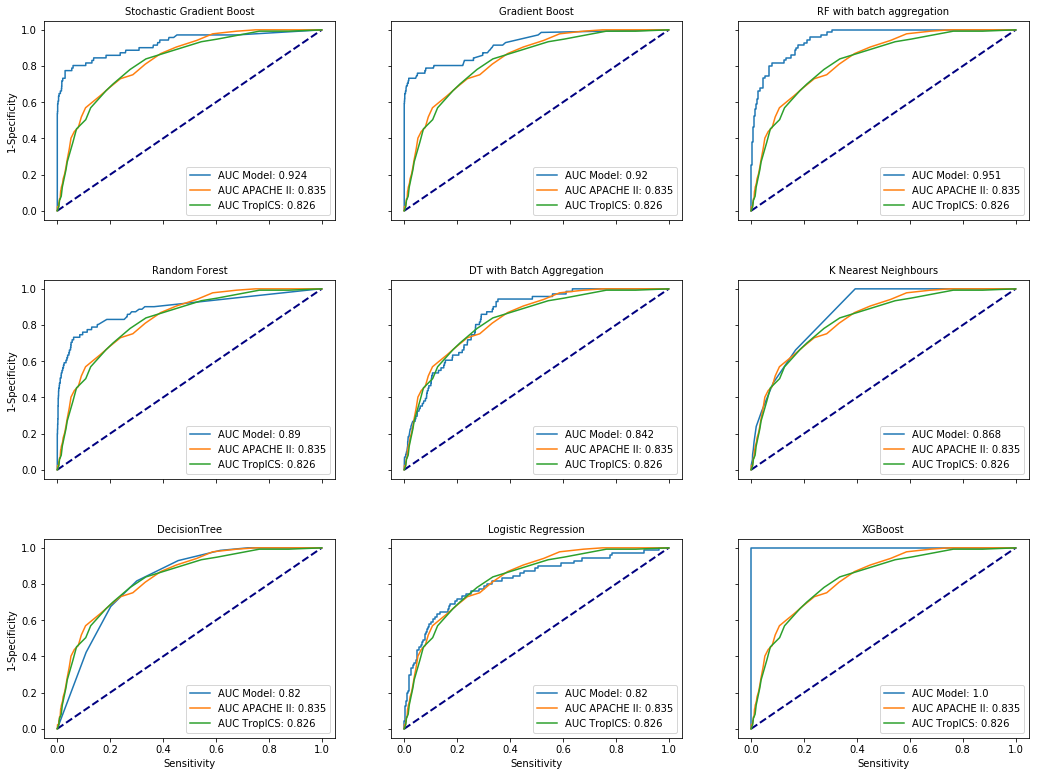

In [13]:
case_tr = preprocess.evaluate(pred_train, targ_train).testPerformance(data_type='train', 
                                                              models=models, ap_tr_list=apache_trop)

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.9244659181959474
Confidence interval for the score: [0.887 - 0.955]
Optimal threshold in training set is: 0.119
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.9198756624738149
Confidence interval for the score: [0.886 - 0.951]
Optimal threshold in training set is: 0.106
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Score in training set: 0.9507669733272839
Confidence interval for the score: [0.935 - 0.965]
Optimal threshold in training set is: 0.07
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.8904613424205272
Confidence interval for the score: [0.849 - 0.928]
Optimal threshold in training set is: 0.081
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Score in training set: 0.8419571576132601
Confidence interval for

IndexError: index 3 is out of bounds for axis 0 with size 3

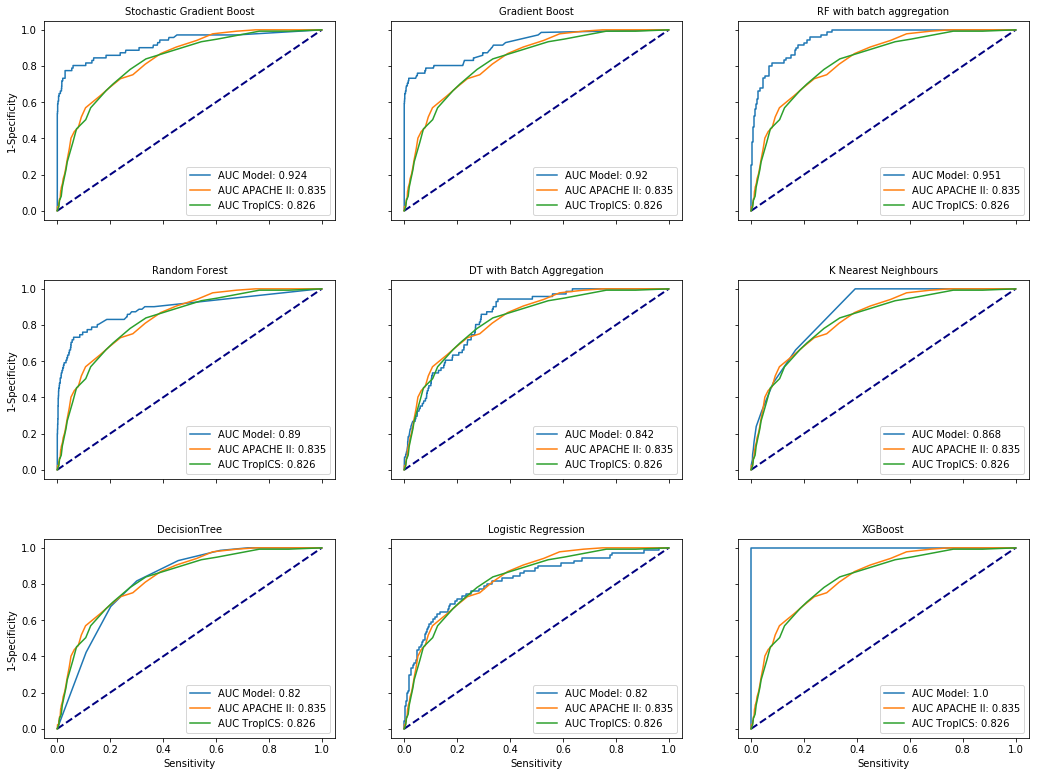

In [15]:
case_ts = preprocess.evaluate(pred_train, targ_train).testPerformance(data_type='test', 
                                                              models=models, ap_tr_list=apache_trop)

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.8369928400954654
Confidence interval for the score: [0.780 - 0.889]
Optimal threshold in training set is: 0.022
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.8222434367541765
Confidence interval for the score: [0.755 - 0.882]
Optimal threshold in training set is: 0.026
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Score in training set: 0.848019093078759
Confidence interval for the score: [0.795 - 0.897]
Optimal threshold in training set is: 0.03
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.8320763723150358
Confidence interval for the score: [0.763 - 0.895]
Optimal threshold in training set is: 0.03
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Score in training set: 0.8504057279236277
Confidence interval for t

IndexError: index 3 is out of bounds for axis 0 with size 3

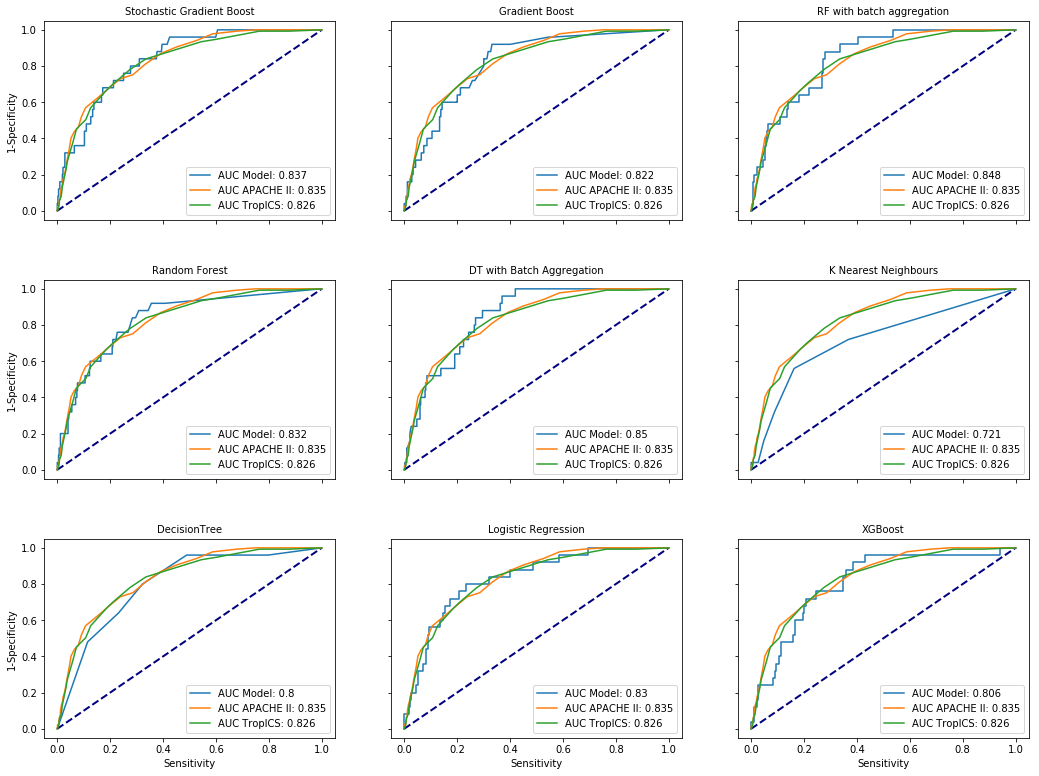

In [16]:
case_h = preprocess.evaluate(pred_h, targ_h).testPerformance(data_type='holdout', 
                                                              models=models, ap_tr_list=apache_trop)

Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.7574490461988561
Confidence interval for the score: [0.681 - 0.83]
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.7567564385199638
Confidence interval for the score: [0.675 - 0.83]
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Score in training set: 0.634246178760697
Confidence interval for the score: [0.537 - 0.719]
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.5993453274550351
Confidence interval for the score: [0.506 - 0.686]
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Score in training set: 0.23605634160772826
Confidence interval for the score: [0.171 - 0.32]
Preparing dataset...
Evaluating...

Estimator: K Nearest Neighbours
Score in training set: 0.22381555335242578
Confidence interval for the score: [0.160 - 0.304]
Preparin

IndexError: index 3 is out of bounds for axis 0 with size 3

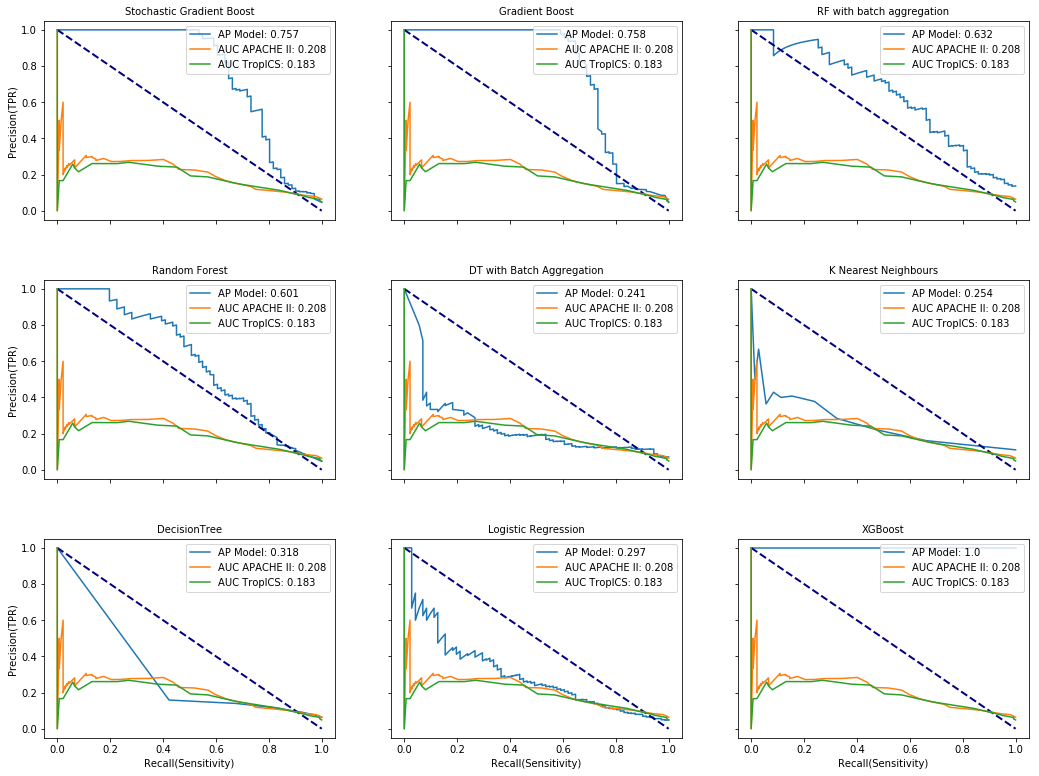

In [32]:
pr_case = getPRCurves(pred_train, targ_train, data_type='train', models=models, ap_tr_list=apache_trop)

Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.27917154205585315
Confidence interval for the score: [0.165 - 0.421]
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.21528675821646184
Confidence interval for the score: [0.122 - 0.355]
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Score in training set: 0.24812359640753306
Confidence interval for the score: [0.151 - 0.4]
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.244126783850596
Confidence interval for the score: [0.142 - 0.399]
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Score in training set: 0.22344002582555908
Confidence interval for the score: [0.132 - 0.337]
Preparing dataset...
Evaluating...

Estimator: K Nearest Neighbours
Score in training set: 0.18498536405313323
Confidence interval for the score: [0.111 - 0.308]
Prep

IndexError: index 3 is out of bounds for axis 0 with size 3

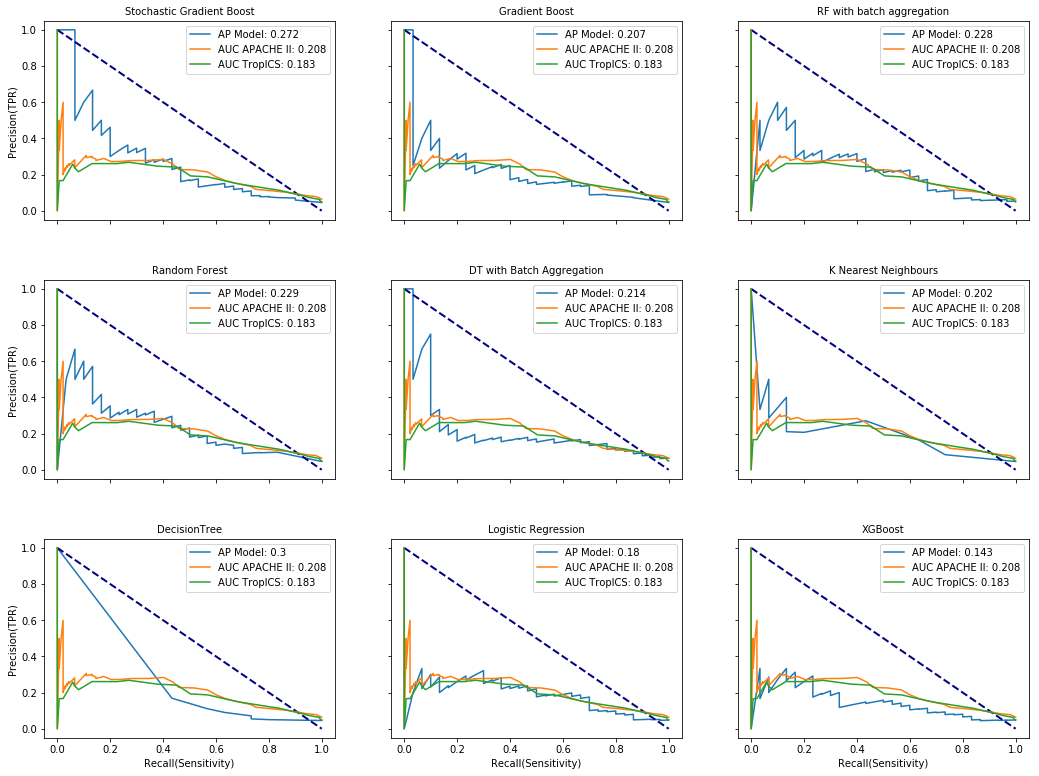

In [33]:
pr_case = getPRCurves(pred_train, targ_train, data_type='test', models=models, ap_tr_list=apache_trop)

Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.25675786708356463
Confidence interval for the score: [0.172 - 0.404]
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.19862321672334793
Confidence interval for the score: [0.139 - 0.304]
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Score in training set: 0.23135561963123824
Confidence interval for the score: [0.155 - 0.364]
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.21608737123689814
Confidence interval for the score: [0.150 - 0.338]
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Score in training set: 0.2191223059729278
Confidence interval for the score: [0.154 - 0.338]
Preparing dataset...
Evaluating...

Estimator: K Nearest Neighbours
Score in training set: 0.1542195286120231
Confidence interval for the score: [0.095 - 0.237]
Pr

IndexError: index 3 is out of bounds for axis 0 with size 3

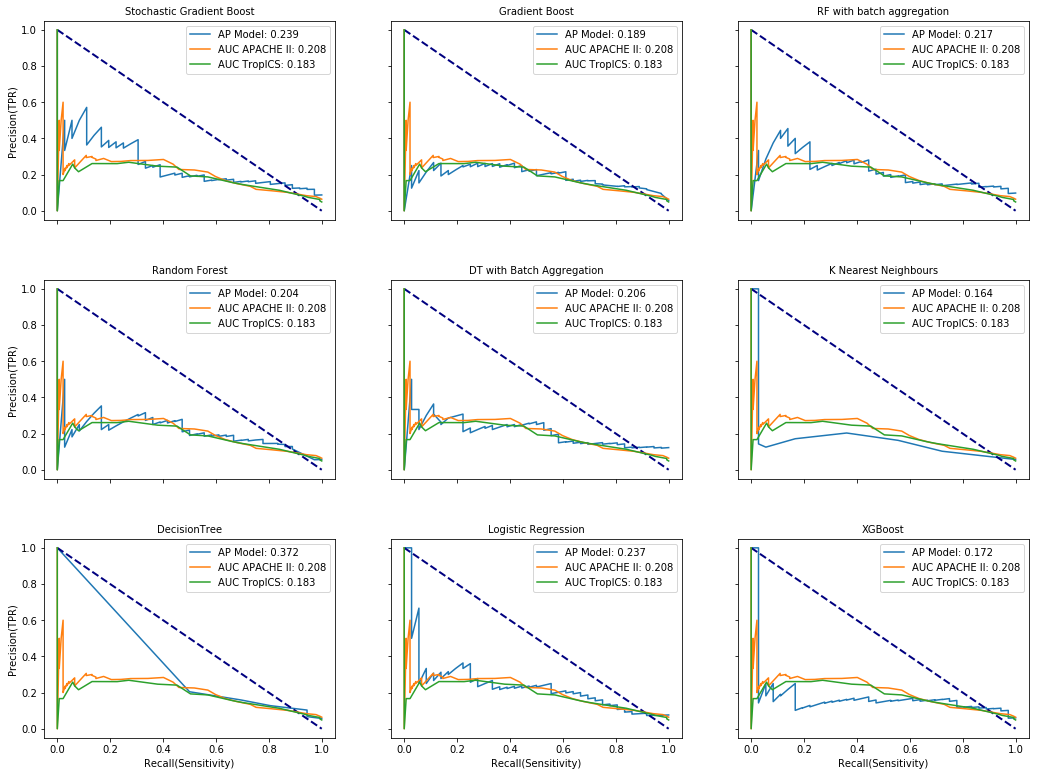

In [34]:
pr_case = getPRCurves(pred_h, targ_h, data_type='holdout', models=models, ap_tr_list=apache_trop)

In [31]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

def getPRCurves(pred, targ, data_type, models, ap_tr_list):
    
    import matplotlib.pyplot as plt
    
    # Dictionary of pipelines
    model_dict = {0: 'Stochastic Gradient Boost', 1: 'Gradient Boost', 2: 'RF with batch aggregation', 
                3: 'Random Forest', 4: 'DT with Batch Aggregation', 5: 'K Nearest Neighbours', 6: 'DecisionTree', 
                7: 'Logistic Regression', 8: 'XGBoost', 9: 'Neural Network'}
    prc_ls = []
    count_c = 0; count_r = 0
    fig, axs = plt.subplots(3, 3)

    print('Evaluating performance...')
    case = []
    for idx, model in enumerate(models):        
        t = []; bag = []
        # Preparing Dataset
        print('Preparing dataset...')
        X_train, X_test, y_train, y_test = train_test_split(pred, targ, test_size=0.3, stratify=targ, 
                                                           random_state=62)
        if (data_type=='test'):
            X_train=X_test
            y_train=y_test
        elif (data_type=='holdout'):
            X_train=pred
            y_train=targ
        # Evaluating
        print('Evaluating...')
        bag.append({'model':model_dict[idx]})
        print('\nEstimator: %s' % model_dict[idx])
        # Predict
        if (model_dict[idx] == 'Logistic Regression'):
            y_train_pred = model.predict_proba(X_train)[:, 1]
        else:
            y_train_pred = model.predict(X_train)
        # Find ROC Score
        ap_score = average_precision_score(y_train, y_train_pred)
        print('Score in training set: %s' % ap_score)
        bag.append({'score':ap_score})
        # Finding confidence intervals
        confidence_lower, confidence_upper = preprocess.Boot(y_train, y_train_pred).bootstrap('ap')
        print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
        confidence_lower, confidence_upper))
        bag.append({'CI':(confidence_lower, confidence_upper)})
        # Finding optimal cut off
        precision, recall, _ = precision_recall_curve(y_train, y_train_pred)
        mod_auc = auc(recall, precision)
        case.append({data_type:bag})
        # Finding apache and tropics counterparts
        sur_all = ap_tr_list[2]; ap_all = ap_tr_list[1]; trop_all = ap_tr_list[0]
        
        precision_ap, recall_ap, _ = precision_recall_curve(sur_all, ap_all)
        precision_tr, recall_tr, _ = precision_recall_curve(sur_all, trop_all)
        apache_ap = average_precision_score(sur_all, ap_all)
        trop_ap = average_precision_score(sur_all, trop_all)

        # Plotting ROCs
        axs[count_r, count_c].plot(recall, precision, label='AP Model: {}'.format(round(mod_auc, 3)))
        axs[count_r, count_c].plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
        axs[count_r, count_c].set_title(model_dict[idx], fontsize = 10)
        axs[count_r, count_c].plot(recall_ap, precision_ap, label='AUC APACHE II: {}'.format(round(apache_ap, 3)))
        axs[count_r, count_c].plot(recall_tr, precision_tr, label='AUC TropICS: {}'.format(round(trop_ap, 3)))
        axs[count_r, count_c].legend(loc='upper right')
        for ax in axs.flat:
            ax.set(xlabel='Recall(Sensitivity)', ylabel='Precision(TPR)')
        for ax in axs.flat:
            ax.label_outer()

        count_c +=1
        if (count_c>2):
            count_r +=1
            count_c = 0

        plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=1.0)
        fig1 = plt.gcf()
        fig1.set_size_inches(16, 12)
        fig1.savefig('PRC_{}.png'.format(data_type), dpi=600)
    return case

In [10]:
def reliability_curve(y_true, y_score, bins=10, normalize=False):
    
    if normalize:  # Normalize scores into bin [0, 1]
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    bin_width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0 - bin_width, bins) + bin_width / 2

    y_score_bin_mean = np.empty(bins)
    empirical_prob_pos = np.empty(bins)
    for i, threshold in enumerate(bin_centers):
        # determine all samples where y_score falls into the i-th bin
        bin_idx = np.logical_and(threshold - bin_width / 2 < y_score,
                                 y_score <= threshold + bin_width / 2)
        # Store mean y_score and mean empirical probability of positive class
        y_score_bin_mean[i] = y_score[bin_idx].mean()
        empirical_prob_pos[i] = y_true[bin_idx].mean()
    return y_score_bin_mean, empirical_prob_pos

In [17]:
def getCalibCurves(pred, targ, data_type, models, ap_tr_list):
    
    import matplotlib.pyplot as plt
    
    # Dictionary of pipelines
    model_dict = {0: 'Stochastic Gradient Boost', 1: 'Gradient Boost', 2: 'RF with batch aggregation', 
                3: 'Random Forest', 4: 'DT with Batch Aggregation', 5: 'K Nearest Neighbours', 6: 'DecisionTree', 
                7: 'Logistic Regression', 8: 'XGBoost', 9: 'Neural Network'}
    prc_ls = []
    count_c = 0; count_r = 0
    fig, axs = plt.subplots(3, 3)
    print('Evaluating performance...')
    case = []
    reliability_scores = {}
    for idx, model in enumerate(models):        
        # Preparing Dataset
        print('Preparing dataset...')
        X_train = pred
        y_train = targ
        # Evaluating
        print('Evaluating...')
        print('\nEstimator: %s' % model_dict[idx])
        # Predict
        if (model_dict[idx] == 'Logistic Regression'):
            y_score_bin_mean, empirical_prob_pos = reliability_curve(y_train, model.predict_proba(X_train)[:, 1], bins=5, normalize=True)
        else:
            y_score_bin_mean, empirical_prob_pos = reliability_curve(y_train, model.predict(X_train), bins=5)
        
        # Plotting 
        axs[count_r, count_c].plot([0.0, 1.0], [0.0, 1.0], 'k', label="Perfect")
        scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
        axs[count_r, count_c].plot(y_score_bin_mean[scores_not_nan],empirical_prob_pos[scores_not_nan], label=model_dict[idx])
        axs[count_r, count_c].set_title(model_dict[idx], fontsize = 10)
        axs[count_r, count_c].legend(loc='upper right')
        for ax in axs.flat:
            ax.set(xlabel='Predicted probability', ylabel='Observed probability')
        for ax in axs.flat:
            ax.label_outer()

        count_c +=1
        if (count_c>2):
            count_r +=1
            count_c = 0

        plt.tight_layout(pad=0.1, w_pad=0.2, h_pad=0.2)
        fig1 = plt.gcf()
        fig1.set_size_inches(12, 16)
        fig1.savefig('Calib_{}.png'.format(data_type), dpi=600)
    return case

Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Preparing dataset...
Evaluating...

Estimator: Random Forest
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Preparing dataset...
Evaluating...

Estimator: K Nearest Neighbours
Preparing dataset...
Evaluating...

Estimator: DecisionTree
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Preparing dataset...
Evaluating...

Estimator: XGBoost
Preparing dataset...
Evaluating...

Estimator: Neural Network


IndexError: too many indices for array

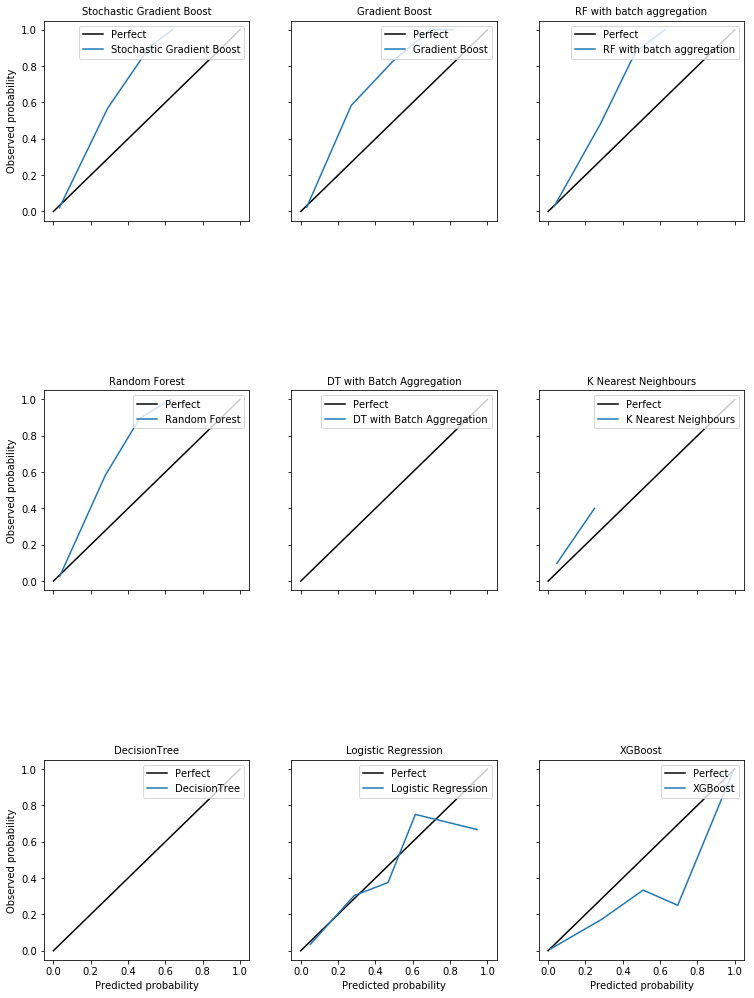

In [18]:
getCalibCurves(pred_train, targ_train, data_type='train', models=models, ap_tr_list=apache_trop)

Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Preparing dataset...
Evaluating...

Estimator: Random Forest
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Preparing dataset...
Evaluating...

Estimator: K Nearest Neighbours
Preparing dataset...
Evaluating...

Estimator: DecisionTree
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Preparing dataset...
Evaluating...

Estimator: XGBoost
Preparing dataset...
Evaluating...

Estimator: Neural Network


IndexError: too many indices for array

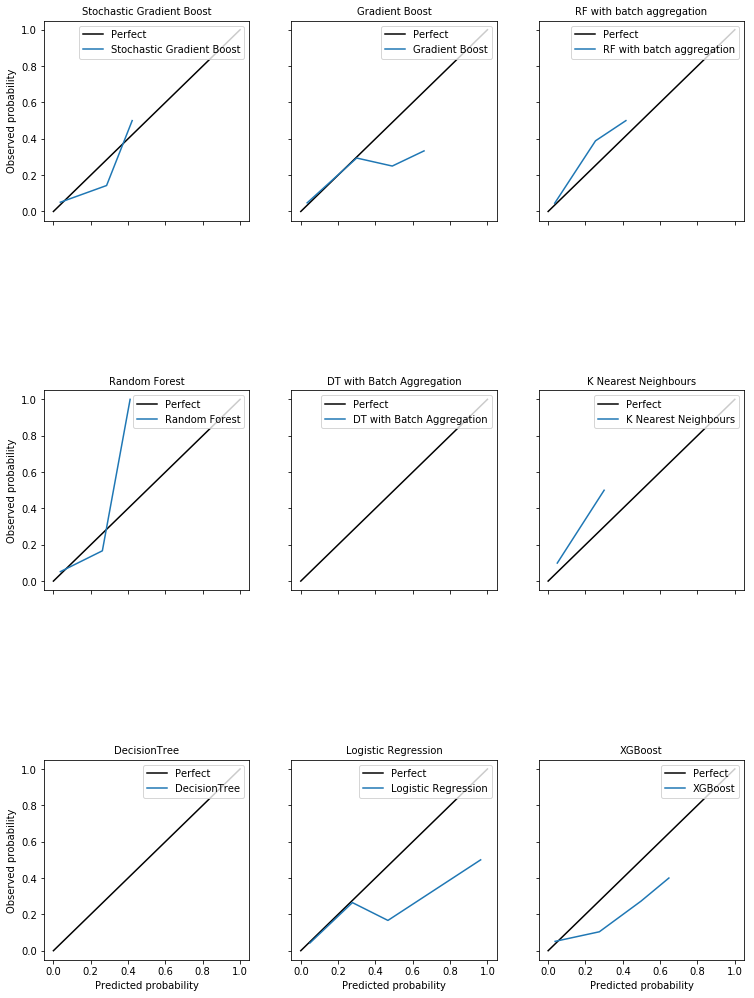

In [19]:
getCalibCurves(pred_h, targ_h, data_type='holdout', models=models, ap_tr_list=apache_trop)

In [39]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline(steps=[('clf', RandomForestClassifier(random_state=62))])
params_rf = {
    'clf__max_depth' : np.arange(2, 20, 6),
    'clf__max_leaf_nodes': np.arange(2,20,6), 
    'clf__min_impurity_split': [0.01, 0.1],
    'clf__n_estimators': np.arange(50, 70, 10)
}
gs_rf = RandomizedSearchCV(estimator=pipe_rf, 
                    param_distributions=params_rf,
                    n_iter=25,
                    scoring='roc_auc',
                    cv=5)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)

0.8085954096682061

In [40]:
gs_rf.best_params_

{'clf__n_estimators': 60,
 'clf__min_impurity_split': 0.01,
 'clf__max_leaf_nodes': 8,
 'clf__max_depth': 14}

In [41]:
calib_pipe_rf = Pipeline(steps=[('calibrator', CalibratedClassifierCV(RandomForestClassifier(max_depth=14,
                                                                                              max_leaf_nodes=8,
                                                                                              min_impurity_split=0.01,
                                                                                              n_estimators=60), 
                                                                      cv=5, method='sigmoid'))])
calib_pipe_rf.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('calibrator', CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=8,
            min_impurity_decrease=0.0, min_impurity_split=0.01,
            min_samples_leaf=1, min..., random_state=None, verbose=0,
            warm_start=False),
            cv=5, method='sigmoid'))])

In [43]:
y_train_pred = calib_pipe_rf.predict(X_train)

In [45]:
sum(y_train_pred)

18

In [46]:
reliability_scores = {}
reliability_scores['DT'] = reliability_curve(y_train, y_train_pred, bins=10)

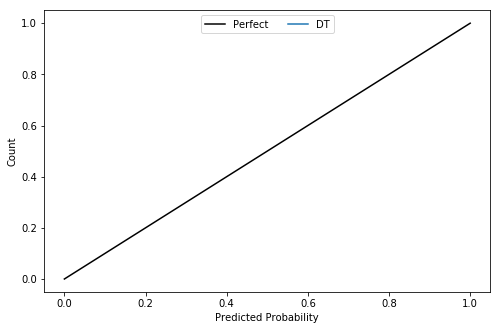

In [49]:
import matplotlib.pyplot as plt
plt.figure(0, figsize=(8, 8))
plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.plot([0.0, 1.0], [0.0, 1.0], 'k', label="Perfect")
for method, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    plt.plot(y_score_bin_mean[scores_not_nan],
             empirical_prob_pos[scores_not_nan], label=method)
plt.ylabel("Empirical probability")
plt.legend(loc=0)

plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend(loc='upper center', ncol=2)
plt.show()